In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_excel('/content/drive/MyDrive/Final_features_v2.xlsx')

In [4]:
data2 = pd.read_excel('/content/drive/MyDrive/subsequent_funded_v2.xlsx')

In [5]:
data2.columns

Index(['OpportunityID', 'OpportunityName', 'Renewal_OpportunityID',
       'Renewal_PreviousCollectionStatus', 'Renewal_PreviousOpportunityID',
       'Renewal_PreviousCreatedDate', 'Renewal_PreviousRenewals_Manager',
       'Renewal_PreviouszzStatus', 'Renewal_PreviousPace',
       'Renewal_PreviousDaysSinceLastPayment',
       'Renewal_PreviousPaidPercentageOfRTR', 'Renewal_PreviousCreditScore',
       'Renewal_CountPreviousDeals', 'Renewal_PreviousCountBounces',
       'Renewal_PreviousPosition', 'Renewal_PreviousHBwLCF',
       'Renewal_PreviousHBwoLCF', 'Renewal_PreviousAvgMonthRevenue',
       'Renewal_PreviousAvgDailyBalance', 'Renewal_TwoWeekBounces',
       'NumberOfBankStatements', 'BankStatement_MA_OverdraftDays',
       'BankStatement_MA_NumReturnItems', 'BankStatement_Sum_NumReturnItems',
       'LastBankStatement_OverdraftDays', 'Credit_Score__c',
       'Time_in_Business__c', 'Is_this_Business_home_based__c',
       'BBC_Position__c', 'HB_with_LCF_Payment__c', 'HBwoLCF',

In [6]:
data2.drop(index=[1710, 2766], inplace = True) #removing some write_off missing values

In [7]:
data2[data2['Time_in_Business__c']<0].index # removing negative values

Int64Index([21, 93, 126, 217, 380, 383, 531, 724, 1034, 1440], dtype='int64')

In [8]:
data2.drop(index=[21, 93, 126, 217, 380, 383, 531, 724, 1034, 1440], inplace = True)

In [9]:
data['WriteOff_YN'][15:25]

15    1
16    0
17    0
18    0
19    1
20    1
21    1
22    0
23    1
24    0
Name: WriteOff_YN, dtype: int64

In [10]:
data2.reset_index(drop = True,inplace = True)

In [11]:
data2['WriteOff_YN'][15:25]

15    1.0
16    0.0
17    0.0
18    0.0
19    1.0
20    1.0
21    1.0
22    0.0
23    1.0
24    0.0
Name: WriteOff_YN, dtype: float64

In [12]:
data2[15:25]

,OpportunityID,OpportunityName,Renewal_OpportunityID,Renewal_PreviousCollectionStatus,Renewal_PreviousOpportunityID,Renewal_PreviousCreatedDate,Renewal_PreviousRenewals_Manager,Renewal_PreviouszzStatus,Renewal_PreviousPace,Renewal_PreviousDaysSinceLastPayment,...,HB_with_LCF_Payment__c,HBwoLCF,Contract_HoldBack__c,AvgMonthRevenue,AvgDailyBalance,NewDeal_YN,ActiveDeal_YN,WriteOff_YN,FundedWriteOffAmount_Gross,FundedWriteOffAmount_Net
15,0062M00000bmvHYQAY,Abale Marketing-Renewal Deal-01042019,0062M00000bmvHYQAY,Other,0064100000aUzn8AAC,2018-10-24 15:34:45,Amina Mayo,Renewed - PIF,100.0,0.0,...,32.79,16.0,17,59887.00,9421.00,0.0,0.0,1.0,18393.32,18393.32
16,0062M00000bmvy8QAA,A2B Trans-Renewal Deal-01042019,0062M00000bmvy8QAA,Other,0064100000b8UBoAAM,2018-11-05 17:25:46,Robert Mason,Renewed - PIF,100.0,0.0,...,0.00,NaN,12,NaN,347.34,0.0,0.0,0.0,NaN,NaN
17,0062M00000bmXd4QAE,All God's Children Learning CT-Renewal Deal-12...,0062M00000bmXd4QAE,Other,0064100000aVbvdAAC,2018-10-29 21:05:57,Robert Mason,Renewed - PIF,100.0,0.0,...,64.53,29.0,36,9929.33,2280.67,0.0,0.0,0.0,NaN,NaN
18,0062M00000bmzgAQAQ,Stone Creek Landscape & Nursery-Renewal Deal-0...,0062M00000bmzgAQAQ,Default,0064100000RVeMUAA1,2018-07-03 15:43:22,Amina Mayo,PIF,100.0,0.0,...,0.00,NaN,12,NaN,5966.33,0.0,0.0,0.0,NaN,NaN
19,0062M00000bmzYVQAY,4 Ace's Trucking-Renewal Deal-01072019,0062M00000bmzYVQAY,Other,0064100000aUi7nAAC,2018-10-22 20:08:38,Monique Williams,Renewed - PIF,100.0,0.0,...,0.00,NaN,12,NaN,1824.34,0.0,0.0,1.0,11999.25,11999.25
20,0062M00000bn0aWQAQ,Blue Rose-Renewal Deal-01072019,0062M00000bn0aWQAQ,Other,0064100000b944DAAQ,2018-11-08 17:03:42,Monique Williams,Renewed - PIF,100.0,0.0,...,67.21,52.0,15,13669.00,2325.67,0.0,0.0,1.0,2298.00,2298.00
21,0062M00000bn1xIQAQ,Kennedy's Trucking-Renewal Deal-01072019,0062M00000bn1xIQAQ,Other,0064100000b8ZwlAAE,2018-11-05 22:47:15,Syed Salman,Renewed - PIF,100.0,0.0,...,0.00,NaN,12,NaN,2136.72,0.0,0.0,1.0,3450.00,3450.00
22,0062M00000bn4hEQAQ,Topaz Investment Advisors-Renewal Deal-01082019,0062M00000bn4hEQAQ,Other,0064100000aSdplAAC,2018-10-05 16:40:54,NaN,Renewed - PIF,81.4,0.0,...,0.00,NaN,12,NaN,6050.79,0.0,0.0,0.0,NaN,NaN
23,0062M00000bn5ncQAA,Coastline Property Management & Leasing-Renewa...,0062M00000bn5ncQAA,Write Off,0062M00000blyT4QAI,2018-12-14 14:48:41,Amina Mayo,Write Off - Settled,100.0,0.0,...,0.00,NaN,12,NaN,23539.33,0.0,0.0,1.0,15462.00,15262.00
24,0062M00000bn78nQAA,Absolute Trucking Company-Renewal Deal-01082019,0062M00000bn78nQAA,Other,0064100000NNMEiAAP,2018-03-27 15:10:19,NaN,Current,NaN,NaN,...,3.51,0.0,12,77695.00,2665.67,0.0,0.0,0.0,NaN,NaN


In [13]:
data2.shape

(2883, 39)

In [14]:

data.index

RangeIndex(start=0, stop=2883, step=1)

In [15]:
data.shape

(2883, 21)

In [16]:
data.columns

Index(['Renewal_PreviousPace', 'Renewal_PreviousPaidPercentageOfRTR',
       'Renewal_PreviousCreditScore', 'Renewal_CountPreviousDeals',
       'Renewal_PreviousCountBounces', 'Renewal_PreviousPosition',
       'Renewal_PreviousHBwLCF', 'Renewal_PreviousHBwoLCF',
       'Renewal_PreviousAvgMonthRevenue', 'Renewal_PreviousAvgDailyBalance',
       'Renewal_TwoWeekBounces', 'NumberOfBankStatements',
       'BankStatement_MA_OverdraftDays', 'BankStatement_MA_NumReturnItems',
       'Credit_Score__c', 'Time_in_Business__c',
       'Is_this_Business_home_based__c', 'HB_with_LCF_Payment__c',
       'Contract_HoldBack__c', 'AvgMonthRevenue', 'WriteOff_YN'],
      dtype='object')

In [17]:
df_decile = pd.concat([data, data2['OpportunityID']], axis=1)

In [18]:
df_decile

,Renewal_PreviousPace,Renewal_PreviousPaidPercentageOfRTR,Renewal_PreviousCreditScore,Renewal_CountPreviousDeals,Renewal_PreviousCountBounces,Renewal_PreviousPosition,Renewal_PreviousHBwLCF,Renewal_PreviousHBwoLCF,Renewal_PreviousAvgMonthRevenue,Renewal_PreviousAvgDailyBalance,...,BankStatement_MA_OverdraftDays,BankStatement_MA_NumReturnItems,Credit_Score__c,Time_in_Business__c,Is_this_Business_home_based__c,HB_with_LCF_Payment__c,Contract_HoldBack__c,AvgMonthRevenue,WriteOff_YN,OpportunityID
0,100.00,0.61,534.0,1,4,1,0.00,NaN,NaN,3320.50,...,2.0,1.333333,533.000000,18.51,0,223.08,40,1873.33,0,0062M00000bmHA5QAM
1,100.00,0.55,537.0,1,0,2,0.00,NaN,NaN,1008.71,...,0.0,0.000000,537.000000,1.16,0,56.37,18,11316.67,1,0062M00000bmhkAQAQ
2,100.00,0.36,0.0,2,0,2,0.00,NaN,NaN,12989.58,...,0.0,0.000000,0.000000,9.22,0,0.00,12,NaN,1,0062M00000bmKPLQA2
3,100.00,0.54,0.0,1,0,2,0.00,NaN,NaN,1526.84,...,3.0,0.000000,0.000000,1.76,0,0.00,12,NaN,1,0062M00000bmlCWQAY
4,100.00,0.61,524.0,1,0,1,0.00,NaN,NaN,4351.47,...,0.0,0.000000,524.000000,5.01,0,0.00,12,NaN,1,0062M00000bmm07QAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2878,100.00,0.56,611.0,1,0,1,31.13,0.0,5026.00,13320.00,...,0.0,0.000000,611.000000,0.91,0,39.65,40,6763.58,1,0062M00000o7zzhQAA
2879,77.93,0.56,659.0,2,15,1,9.92,NaN,200359.15,14148.95,...,20.0,19.333333,523.000000,1.03,1,4.44,12,880725.23,1,0062M00000o80DoQAI
2880,100.00,0.52,736.0,2,0,4,13.69,NaN,28565.08,2458.92,...,3.0,0.000000,1.000000,12.91,1,13.24,13,29542.38,0,0062M00000o82n1QAA
2881,100.00,0.55,641.0,1,0,1,13.13,0.0,62318.62,3442.59,...,1.0,0.000000,548.857043,1.52,1,14.13,14,72944.80,0,0062M00000o82nRQAQ


### Model Training

In [19]:
y=data['WriteOff_YN']
X=data.drop(['WriteOff_YN'],axis = 1)

In [20]:
y.value_counts()

0    2139
1     744
Name: WriteOff_YN, dtype: int64

In [21]:
X.columns

Index(['Renewal_PreviousPace', 'Renewal_PreviousPaidPercentageOfRTR',
       'Renewal_PreviousCreditScore', 'Renewal_CountPreviousDeals',
       'Renewal_PreviousCountBounces', 'Renewal_PreviousPosition',
       'Renewal_PreviousHBwLCF', 'Renewal_PreviousHBwoLCF',
       'Renewal_PreviousAvgMonthRevenue', 'Renewal_PreviousAvgDailyBalance',
       'Renewal_TwoWeekBounces', 'NumberOfBankStatements',
       'BankStatement_MA_OverdraftDays', 'BankStatement_MA_NumReturnItems',
       'Credit_Score__c', 'Time_in_Business__c',
       'Is_this_Business_home_based__c', 'HB_with_LCF_Payment__c',
       'Contract_HoldBack__c', 'AvgMonthRevenue'],
      dtype='object')

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [23]:
print('Shape of x_train is: {}'.format(X_train.shape))
print('Shape of x_test is: {}'.format(X_test.shape))
print('----------------------------------------------')
print('Shape of y_train is: {}'.format(y_train.shape))
print('Shape of y_test is: {}'.format(y_test.shape))

Shape of x_train is: (2306, 20)
Shape of x_test is: (577, 20)
----------------------------------------------
Shape of y_train is: (2306,)
Shape of y_test is: (577,)


In [24]:
y_train.value_counts()

0    1717
1     589
Name: WriteOff_YN, dtype: int64

In [25]:
y_test.value_counts()

0    422
1    155
Name: WriteOff_YN, dtype: int64

In [26]:
#checking the skewness
print('Percentage of  having WriteOFF_YN = 1: {}%'.format(np.round((list(y_train).count(1)/len(y_train))*100)))
print('Percentage of  having WriteOFF_YN = 0: {}%'.format(np.round(list(y_train).count(0)/len(y_train)*100)))

Percentage of  having WriteOFF_YN = 1: 26.0%
Percentage of  having WriteOFF_YN = 0: 74.0%


#XGBoost Parameters Explanation


1.   eta - Learning rate - Prevents overfitting - Default = 0.3 - Range = [0,1]
2.   gamma - min_split_loss - Min loss reduction for a further partition - default = 0 - range = [0,infinity] (Higher gamma value means smaller loss reduction which means more splits. As a result, more conservative model,chances of improvement in accuracy.Higher values can also cause overfitting).
3.  lambda - L2 regularisation - default=1 - Higher value means more conservative model, likely to overfit
4. alpha - L1 regularization - default=0 - Higher values lead to more conservative model, likely to overfit 
5. scale_pos_weight - default=1 - Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances).









In [27]:
parameters = {
    'eval_metric':['aucpr'],
    'use_label_encoder':[False],
    'n_estimators':[1,5,10,15,20,25,30,40,50,100], # number of decision trees used in Xgboost model
    'scale_pos_weight': [1,2,3,4,5,6,7,8,9,10], # used to tackle unbalanced datasets(same as upsampling, SMOTE,etc)
    'subsample':[0.75], # how much % of data you are taking for estimator building.
    'lambda':[1,50], #perform L2 regularization on leaf weights(tackle overfitting)(control how deep a tree can grow)
    'eta':[0.01], # Learning rate(new weight updation after every epoch in a conservative manner)
    'gamma':[0.25], #Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
    'colsample_bytree':[1],
    'colsample_bylevel':[1],
    'colsample_bynode':[1]
}

In [28]:
from datetime import datetime as dt
start = dt.now()
x_cfl = XGBClassifier() #initializing xgboost model

clf = GridSearchCV(estimator=x_cfl, 
                   param_grid=parameters, 
                   scoring='roc_auc',
                   n_jobs=-1, 
                   cv=5, 
                   return_train_score=True)

clf.fit(X_train,y_train)
running_secs = (dt.now() - start).seconds

In [29]:
print(running_secs,'secs')

74 secs


In [30]:
#best parameters after training
clf.best_estimator_

XGBClassifier(eta=0.01, eval_metric='aucpr', gamma=0.25, lambda=1,
              n_estimators=40, scale_pos_weight=4, subsample=0.75,
              use_label_encoder=False)

In [31]:
predict_y_test = clf.predict(X_test)
predict_y_proba_test = clf.predict_proba(X_test)
predict_y_train = clf.predict(X_train)

In [32]:
#converting this into a dataframe as y_test is a series. {we get retained indexes}
check = pd.DataFrame(y_test)
check

,WriteOff_YN
471,0
1453,0
2379,0
1601,0
1094,1
...,...
109,0
2834,0
163,0
1921,0


In [33]:
check['Predicted Values'] = predict_y_test

In [34]:
check

,WriteOff_YN,Predicted Values
471,0,1
1453,0,0
2379,0,0
1601,0,0
1094,1,1
...,...,...
109,0,1
2834,0,1
163,0,0
1921,0,1


In [35]:
predict_y_proba_test

array([[0.35501194, 0.64498806],
       [0.64724684, 0.35275313],
       [0.5595429 , 0.4404571 ],
       ...,
       [0.5257737 , 0.4742263 ],
       [0.26042634, 0.73957366],
       [0.61826724, 0.38173276]], dtype=float32)

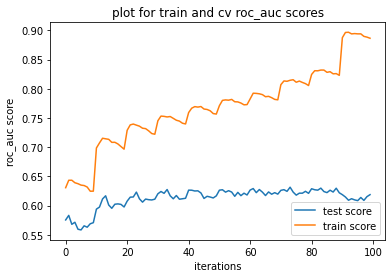

In [36]:
#here test score refers to the cv score
x_axis = [i for i in range(100)]
plt.plot(x_axis,clf.cv_results_['mean_test_score'][:100])
plt.plot(x_axis,clf.cv_results_['mean_train_score'][:100])
plt.legend(["test score", "train score"], loc ="lower right")
plt.xlabel('iterations')
plt.ylabel('roc_auc score')
plt.title('plot for train and cv roc_auc scores')
plt.show()

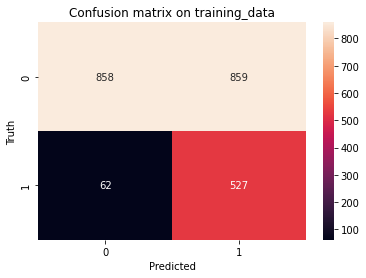

----------------------------
TP: 527
TN: 858
FP: 859
FN: 62
F1-score: 0.5336708860759494
accuracy: 0.6006071118820469


In [37]:
# this is the confusion matrix for training data 
#cf_matrix=confusion_matrix(predict_y_train, y_train)
#cf_matrix

sns.heatmap(confusion_matrix(y_train,predict_y_train), annot=True, fmt='d')
plt.title('Confusion matrix on training_data')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
print("----------------------------")

tn, fp, fn, tp = confusion_matrix(y_train, predict_y_train).ravel()
print('TP: {}'.format(tp))
print('TN: {}'.format(tn))
print('FP: {}'.format(fp))
print('FN: {}'.format(fn))


print('F1-score: {}'.format(f1_score(predict_y_train,y_train)))
print('accuracy: {}'.format((tp+tn)/(tp+tn+fp+fn)))

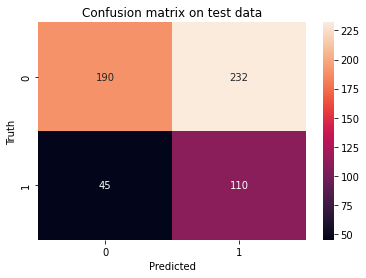

----------------------------
----------------------------
TP: 110
TN: 190
FP: 232
FN: 45
----------------------------
F1-score: 0.44265593561368205
accuracy: 0.5199306759098787


In [38]:
sns.heatmap(confusion_matrix(y_test,predict_y_test), annot=True, fmt='d')
plt.title('Confusion matrix on test data')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
print("----------------------------")

tn, fp, fn, tp = confusion_matrix(y_test,predict_y_test).ravel()
print("----------------------------")

print('TP: {}'.format(tp))
print('TN: {}'.format(tn))
print('FP: {}'.format(fp))
print('FN: {}'.format(fn))
print("----------------------------")

print('F1-score: {}'.format(f1_score(y_test,predict_y_test)))
print('accuracy: {}'.format((tp+tn)/(tp+tn+fp+fn)))


In [39]:
predict_y_proba_test

array([[0.35501194, 0.64498806],
       [0.64724684, 0.35275313],
       [0.5595429 , 0.4404571 ],
       ...,
       [0.5257737 , 0.4742263 ],
       [0.26042634, 0.73957366],
       [0.61826724, 0.38173276]], dtype=float32)

In [40]:
write_off1 = []
for i in predict_y_proba_test:
  write_off1.append(i[1])


In [41]:
check['Predicted_Prob_WO = 1'] = write_off1

In [42]:
check

,WriteOff_YN,Predicted Values,Predicted_Prob_WO = 1
471,0,1,0.644988
1453,0,0,0.352753
2379,0,0,0.440457
1601,0,0,0.435265
1094,1,1,0.719167
...,...,...,...
109,0,1,0.807117
2834,0,1,0.552645
163,0,0,0.474226
1921,0,1,0.739574


In [43]:
check['OpportunityID'] = None

In [44]:
for i in check.index:
  check['OpportunityID'][i] = data2['OpportunityID'][i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
check

,WriteOff_YN,Predicted Values,Predicted_Prob_WO = 1,OpportunityID
471,0,1,0.644988,0062M00000iaEtlQAE
1453,0,0,0.352753,0062M00000lVc2RQAS
2379,0,0,0.440457,0062M00000nGklEQAS
1601,0,0,0.435265,0062M00000lWs8HQAS
1094,1,1,0.719167,0062M00000kze1sQAA
...,...,...,...,...
109,0,1,0.807117,0062M00000dhsQwQAI
2834,0,1,0.552645,0062M00000nZdn2QAC
163,0,0,0.474226,0062M00000dkn6GQAQ
1921,0,1,0.739574,0062M00000mhNoMQAU


In [46]:
print("Max_propability_value: ", check["Predicted_Prob_WO = 1"].max())
print("Min_propability_value: ", check["Predicted_Prob_WO = 1"].min())

Max_propability_value:  0.8168716
Min_propability_value:  0.12804422


Max_Probabilty - 0.81, Min_Probabilty - 0.12 - 0 percentile value
Explaination - In the range of 0 to 1, .81 - 100 percentile value

How deciles are made:
1) 10 deciles are formed based on the distribution of quantiles - we need to break percentile into 10 bins

In [47]:
check['Decile'] = None

In [48]:
for i in check.index:
  
  if check["Predicted_Prob_WO = 1"][i]>check["Predicted_Prob_WO = 1"].quantile(0.90):
    d=1
  elif (check["Predicted_Prob_WO = 1"][i] > check["Predicted_Prob_WO = 1"].quantile(0.80)) & (check["Predicted_Prob_WO = 1"][i] <= check["Predicted_Prob_WO = 1"].quantile(0.90)):
    d=2

  elif (check["Predicted_Prob_WO = 1"][i] > check["Predicted_Prob_WO = 1"].quantile(0.70)) & (check["Predicted_Prob_WO = 1"][i] <= check["Predicted_Prob_WO = 1"].quantile(0.80)):
    d=3
  
  elif (check["Predicted_Prob_WO = 1"][i] > check["Predicted_Prob_WO = 1"].quantile(0.60)) & (check["Predicted_Prob_WO = 1"][i] <= check["Predicted_Prob_WO = 1"].quantile(0.70)):
    d=4

  elif (check["Predicted_Prob_WO = 1"][i] > check["Predicted_Prob_WO = 1"].quantile(0.50)) & (check["Predicted_Prob_WO = 1"][i] <= check["Predicted_Prob_WO = 1"].quantile(0.60)):
    d=5

  elif (check["Predicted_Prob_WO = 1"][i] > check["Predicted_Prob_WO = 1"].quantile(0.40)) & (check["Predicted_Prob_WO = 1"][i] <= check["Predicted_Prob_WO = 1"].quantile(0.50)):
    d=6

  elif (check["Predicted_Prob_WO = 1"][i] > check["Predicted_Prob_WO = 1"].quantile(0.30)) & (check["Predicted_Prob_WO = 1"][i] <= check["Predicted_Prob_WO = 1"].quantile(0.40)):
    d=7

  elif (check["Predicted_Prob_WO = 1"][i] > check["Predicted_Prob_WO = 1"].quantile(0.20)) & (check["Predicted_Prob_WO = 1"][i] <= check["Predicted_Prob_WO = 1"].quantile(0.30)):
    d=8

  elif (check["Predicted_Prob_WO = 1"][i] > check["Predicted_Prob_WO = 1"].quantile(0.10)) & (check["Predicted_Prob_WO = 1"][i] <= check["Predicted_Prob_WO = 1"].quantile(0.20)):
    d=9

  else:
    d = 10
  
  check['Decile'][i] = d

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
check

,WriteOff_YN,Predicted Values,Predicted_Prob_WO = 1,OpportunityID,Decile
471,0,1,0.644988,0062M00000iaEtlQAE,3
1453,0,0,0.352753,0062M00000lVc2RQAS,9
2379,0,0,0.440457,0062M00000nGklEQAS,8
1601,0,0,0.435265,0062M00000lWs8HQAS,8
1094,1,1,0.719167,0062M00000kze1sQAA,1
...,...,...,...,...,...
109,0,1,0.807117,0062M00000dhsQwQAI,1
2834,0,1,0.552645,0062M00000nZdn2QAC,5
163,0,0,0.474226,0062M00000dkn6GQAQ,7
1921,0,1,0.739574,0062M00000mhNoMQAU,1


In [50]:
check['Decile'].isna().sum()

0

In [51]:
check['Decile'].unique()

array([3, 9, 8, 1, 10, 7, 2, 4, 6, 5], dtype=object)

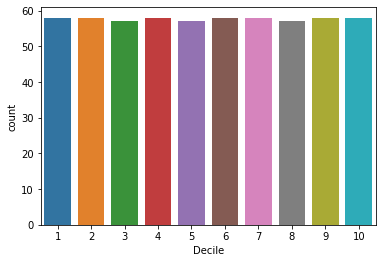

In [52]:
# how many data points are in each decile (value of n)
sns.countplot(check['Decile'])

In [53]:
exp_df = check.copy() 

In [54]:
# sorted dataframe
exp_df = exp_df.sort_values(by=['Predicted_Prob_WO = 1'], ascending = False)

In [55]:
exp_df

,WriteOff_YN,Predicted Values,Predicted_Prob_WO = 1,OpportunityID,Decile
2781,1,1,0.816872,0062M00000nYiYSQA0,1
2189,1,1,0.809647,0062M00000n1aqqQAA,1
109,0,1,0.807117,0062M00000dhsQwQAI,1
1965,1,1,0.802469,0062M00000mTDnyQAG,1
298,1,1,0.795407,0062M00000g9ysmQAA,1
...,...,...,...,...,...
2582,0,0,0.194883,0062M00000nqezRQAQ,10
1803,0,0,0.192579,0062M00000mfGLnQAM,10
460,1,0,0.168171,0062M00000hmBoZQAU,10
544,0,0,0.160743,0062M00000iCZsOQAW,10


Approach for decile analyses:
- Let N = total of data points, P = total no data points with label 0
- Sort all N data points using their probability score.
- Form decile bins. There will be ten bins with equal no of data points in each bin. Size of each bin will be n = N/10.
- For i = 1 to 10
           - Let m_i = no data points with label 0 in the ith bin
           - Let M_i = no data points with label 0 in bins 1 to i  (i.e. M_i = m_i + M_{i-1})
- compute response rate = rr_i = 100*m_i/n.
- compute cumulative gain = cg_i = 100*M_i/P.
- compute lift = cg_i/(10*i) 


In [56]:
N = len(exp_df)
N

577

In [57]:
P = len(exp_df[exp_df["WriteOff_YN"] == 1])
P

155

In [58]:
# As per the standard - total data points in each decile bin should be 57 (where we assume that Precited_WriteOff_YN = 1) but as our model is not performing good - each bin is providing only 23/57 = 23% 
# = 24% as predicted_WriteOff_Yn = 1
exp_df[exp_df["Decile"] == 1]["WriteOff_YN"].value_counts()

0    35
1    23
Name: WriteOff_YN, dtype: int64

In [59]:
exp_df[exp_df["Decile"] == 2]["WriteOff_YN"].value_counts()

0    37
1    21
Name: WriteOff_YN, dtype: int64

In [60]:
m_1 = len(exp_df[(exp_df["Decile"] == 1) & (exp_df["WriteOff_YN"] ==1)])
m_2 = len(exp_df[(exp_df["Decile"] == 2) & (exp_df["WriteOff_YN"] ==1)])
m_3 = len(exp_df[(exp_df["Decile"] == 3) & (exp_df["WriteOff_YN"] ==1)])
m_4 = len(exp_df[(exp_df["Decile"] == 4) & (exp_df["WriteOff_YN"] ==1)])
m_5 = len(exp_df[(exp_df["Decile"] == 5) & (exp_df["WriteOff_YN"] ==1)])
m_6 = len(exp_df[(exp_df["Decile"] == 6) & (exp_df["WriteOff_YN"] ==1)])
m_7 = len(exp_df[(exp_df["Decile"] == 7) & (exp_df["WriteOff_YN"] ==1)])
m_8 = len(exp_df[(exp_df["Decile"] == 8) & (exp_df["WriteOff_YN"] ==1)])
m_9 = len(exp_df[(exp_df["Decile"] == 9) & (exp_df["WriteOff_YN"] ==1)])
m_10 = len(exp_df[(exp_df["Decile"] == 10) & (exp_df["WriteOff_YN"] ==1)])

In [61]:
m_1, m_2

(23, 21)

In [62]:
# this is necessary to calculate cummulative gain
M_1 = m_1
M_2 = M_1 + m_2
M_3 = M_2 + m_3
M_4 = M_3 + m_4
M_5 = M_4 + m_5
M_6 = M_5 + m_6
M_7 = M_6 + m_7
M_8 = M_7 + m_8
M_9 = M_8 + m_9
M_10 = M_9 + m_10

In [63]:
M_1, M_2

(23, 44)

In [64]:
# What is a response rate? How many percentage of merchants are present in decile 1 having WriteOff_YN = 0 - as we are likely dealing to remove defaulty merchants
# compute response rate = rr_i = 100*m_i/n
rr_1 = 100 * m_1/len(exp_df[exp_df["Decile"] == 1])
rr_2 = 100 * m_2/len(exp_df[exp_df["Decile"] == 2])
rr_3 = 100 * m_3/len(exp_df[exp_df["Decile"] == 3])
rr_4 = 100 * m_4/len(exp_df[exp_df["Decile"] == 4])
rr_5 = 100 * m_5/len(exp_df[exp_df["Decile"] == 5])
rr_6 = 100 * m_6/len(exp_df[exp_df["Decile"] == 6])
rr_7 = 100 * m_7/len(exp_df[exp_df["Decile"] == 7])
rr_8 = 100 * m_8/len(exp_df[exp_df["Decile"] == 8])
rr_9 = 100 * m_9/len(exp_df[exp_df["Decile"] == 9])
rr_10 = 100 * m_10/len(exp_df[exp_df["Decile"] == 10])

In [65]:
# rr_i - > basically its a percentage calculation of no. of merchants in each decile bin having writeOff_YN = 1
# rr1_1 = (23/58) %
rr_1 

39.6551724137931

- What is a cummulative gain? - this is being done to check till how many deciles bins - how many % of merchants (i.e. WriteOff_YN = 1) respond in each decile 
- What is gain chart - A Gain Chart can be used to assess what % of merchants respond in each decile. So, rather than targeting customers from lower deciles, 
- customers can be picked up from the top deciles only.
- compute cumulative% of responders  or gain  = cg_i = 100*M_i/P

In [66]:
cg_1 = 100*(M_1/P)
cg_2 = 100*(M_2/P)
cg_3 = 100*(M_3/P)
cg_4 = 100*(M_4/P)
cg_5 = 100*(M_5/P)
cg_6 = 100*(M_6/P)
cg_7 = 100*(M_7/P)
cg_8 = 100*(M_8/P)
cg_9 = 100*(M_9/P)
cg_10 = 100*(M_10/P)

In [67]:
cg_2

28.387096774193548

How to interpret Lift :

- If we target the top two deciles, then we would target 20% of the customers. In the same deciles, the cumulative % of responders is 28.3%. Hence, there is a lift of 1.41

- A lift of 1 means there is no gain compared with the no. of customers targeted at random. Lift greater than 1 means the model approach is better than selecting the customers at random.

- Lift - > (dependent on) - Gain - > (dependent on ) - > % responder (response rate)

- In general, the value of lift will go down as we are adding more deciles. Work will be increased. Lift = 1 means - we are considering every sample, so we are not performing every decile analyses 

- The value of lift in case of good model should be high.s

In [68]:
# Lift formnula = gain / customers % at each decile
# This can be used to identify the deciles which have a higher Lift.
# compute lift = cg_i/(10*i) 
lift_1 = cg_1/(10*1)
lift_2 = cg_2/(10*2)
lift_3 = cg_3/(10*3)
lift_4 = cg_4/(10*4)
lift_5 = cg_5/(10*5)
lift_6 = cg_6/(10*6)
lift_7 = cg_7/(10*7)
lift_8 = cg_8/(10*8)
lift_9 = cg_9/(10*9)
lift_10 = cg_10/(10*10)

In [69]:
rr = [rr_1,rr_2,rr_3,rr_4,rr_5,rr_6,rr_7,rr_8,rr_9,rr_10]
cg = [cg_1,cg_2,cg_3,cg_4,cg_5,cg_6,cg_7,cg_8,cg_9,cg_10]
lift = [lift_1,lift_2,lift_3,lift_4,lift_5,lift_6,lift_7,lift_8,lift_9,lift_10]

In [70]:
max_range = [exp_df[exp_df['Decile']==1]['Predicted_Prob_WO = 1'].max(),exp_df[exp_df['Decile']==2]['Predicted_Prob_WO = 1'].max(),exp_df[exp_df['Decile']==3]['Predicted_Prob_WO = 1'].max(),
             exp_df[exp_df['Decile']==4]['Predicted_Prob_WO = 1'].max(),exp_df[exp_df['Decile']==5]['Predicted_Prob_WO = 1'].max(),exp_df[exp_df['Decile']==6]['Predicted_Prob_WO = 1'].max(),
             exp_df[exp_df['Decile']==7]['Predicted_Prob_WO = 1'].max(),exp_df[exp_df['Decile']==8]['Predicted_Prob_WO = 1'].max(),
             exp_df[exp_df['Decile']==9]['Predicted_Prob_WO = 1'].max(),
             exp_df[exp_df['Decile']==10]['Predicted_Prob_WO = 1'].max()]
max_range

[0.8168716,
 0.70856583,
 0.6591791,
 0.6216626,
 0.58755493,
 0.54013395,
 0.49620152,
 0.44701117,
 0.38968742,
 0.32001874]

In [71]:
min_range = [exp_df[exp_df['Decile']==1]['Predicted_Prob_WO = 1'].min(),exp_df[exp_df['Decile']==2]['Predicted_Prob_WO = 1'].min(),exp_df[exp_df['Decile']==3]['Predicted_Prob_WO = 1'].min(),
             exp_df[exp_df['Decile']==4]['Predicted_Prob_WO = 1'].min(),exp_df[exp_df['Decile']==5]['Predicted_Prob_WO = 1'].min(),exp_df[exp_df['Decile']==6]['Predicted_Prob_WO = 1'].min(),
             exp_df[exp_df['Decile']==7]['Predicted_Prob_WO = 1'].min(),exp_df[exp_df['Decile']==8]['Predicted_Prob_WO = 1'].min(),
             exp_df[exp_df['Decile']==9]['Predicted_Prob_WO = 1'].min(),
             exp_df[exp_df['Decile']==10]['Predicted_Prob_WO = 1'].min()]
min_range

[0.7086369,
 0.6598849,
 0.62188077,
 0.58775365,
 0.54036206,
 0.496914,
 0.44766766,
 0.39007363,
 0.32062724,
 0.12804422]

In [72]:
dict_try = {"Decile": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
            "%_Response_Rate": rr,
            "Cumulative_Gain": cg,
            'Lift': lift,
            'Max Range': max_range,
            'Min Range': min_range}

final_df = pd.DataFrame(dict_try)
final_df


,Decile,%_Response_Rate,Cumulative_Gain,Lift,Max Range,Min Range
0,1,39.655172,14.838710,1.483871,0.816872,0.708637
1,2,36.206897,28.387097,1.419355,0.708566,0.659885
2,3,38.596491,42.580645,1.419355,0.659179,0.621881
3,4,36.206897,56.129032,1.403226,0.621663,0.587754
4,5,21.052632,63.870968,1.277419,0.587555,0.540362
5,6,22.413793,72.258065,1.204301,0.540134,0.496914
6,7,15.517241,78.064516,1.115207,0.496202,0.447668
7,8,17.543860,84.516129,1.056452,0.447011,0.390074
8,9,25.862069,94.193548,1.046595,0.389687,0.320627
9,10,15.517241,100.000000,1.000000,0.320019,0.128044


Analyses from above DataFrame:
- %_Response_Rate - In decile_1 - 39% {23/58} of merchants are captured out of 
total_merchants (58 in that decile) who are likely riskier merchants. Same goes with other deciles as well
- Cumulative_Gain - for 10% of merchant base (in each decile) - there are 23 (out of 58) responders (merchants) who are riskier 
- Similarly for 20 % of merchant base (2 deciles) - there are 28.38 % responses who are likely riskier merchants
- Lift - If we target the top 4 deciles, then we would target 40% of the merchants. In the same deciles, the cumulative % of responders is 56.1%. Hence, there is a lift of 1.40

<BarContainer object of 10 artists>

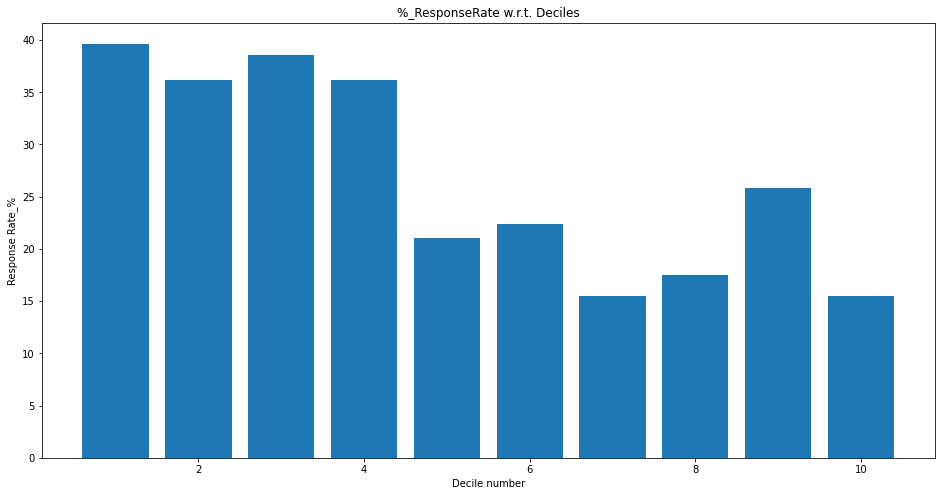

In [75]:
plt.figure(figsize=(16,8))
plt.xlabel("Decile number")
plt.ylabel("Response Rate_%")
plt.title("%_ResponseRate w.r.t. Deciles")
plt.bar(final_df['Decile'],final_df['%_Response_Rate'])

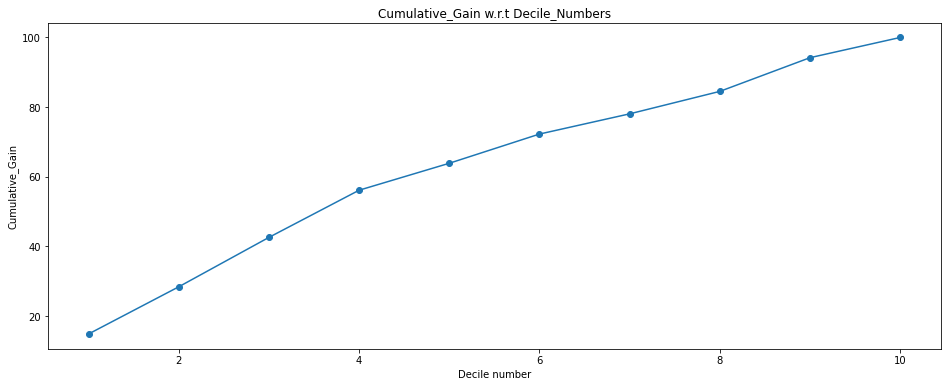

In [76]:
plt.figure(figsize=(16,6))
plt.xlabel("Decile number")
plt.ylabel("Cumulative_Gain")
plt.title("Cumulative_Gain w.r.t Decile_Numbers")
plt.plot(final_df["Decile"], final_df['Cumulative_Gain'],marker='o')

# this graph looks correct to me. {small check - cg_10 = 100*(M_10/P) = 100.00 (we are correct)}

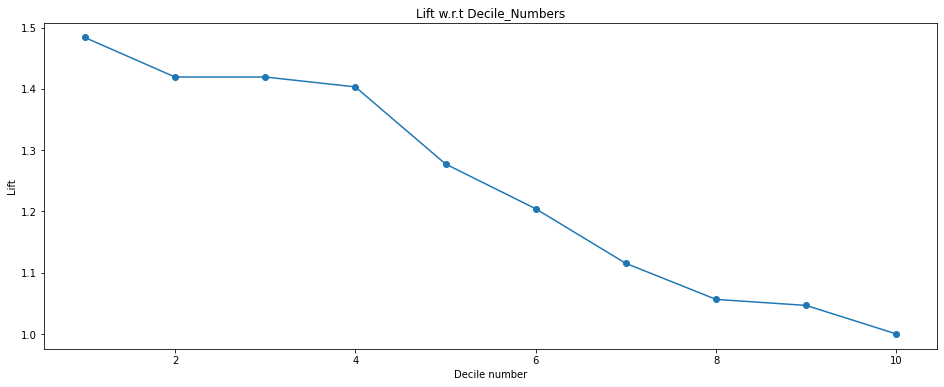

In [77]:
plt.figure(figsize=(16,6))
plt.xlabel("Decile number")
plt.ylabel("Lift")
plt.title("Lift w.r.t Decile_Numbers")
plt.plot(final_df["Decile"], final_df['Lift'],marker='o')

# Now we are sorting the deciles on the bases of Riskier Merchants.

* First four deciles are considering the high riskier merchants.
* And 5th decile's onward are the less riskier merchants 

In [74]:
sorted_df = final_df.sort_values(by=['%_Response_Rate'], ascending=False)
sorted_df

,Decile,%_Response_Rate,Cumulative_Gain,Lift,Max Range,Min Range
0,1,39.655172,14.838710,1.483871,0.816872,0.708637
2,3,38.596491,42.580645,1.419355,0.659179,0.621881
1,2,36.206897,28.387097,1.419355,0.708566,0.659885
3,4,36.206897,56.129032,1.403226,0.621663,0.587754
8,9,25.862069,94.193548,1.046595,0.389687,0.320627
5,6,22.413793,72.258065,1.204301,0.540134,0.496914
4,5,21.052632,63.870968,1.277419,0.587555,0.540362
7,8,17.543860,84.516129,1.056452,0.447011,0.390074
6,7,15.517241,78.064516,1.115207,0.496202,0.447668
9,10,15.517241,100.000000,1.000000,0.320019,0.128044


<BarContainer object of 10 artists>

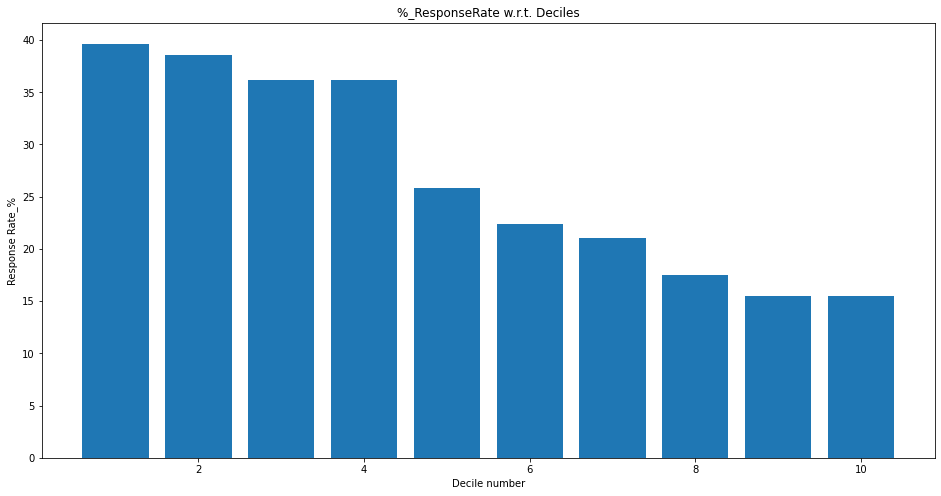

In [80]:
plt.figure(figsize=(16,8))
plt.xlabel("Decile number")
plt.ylabel("Response Rate_%")
plt.title("%_ResponseRate w.r.t. Deciles")
plt.bar(final_df['Decile'],sorted_df['%_Response_Rate'])

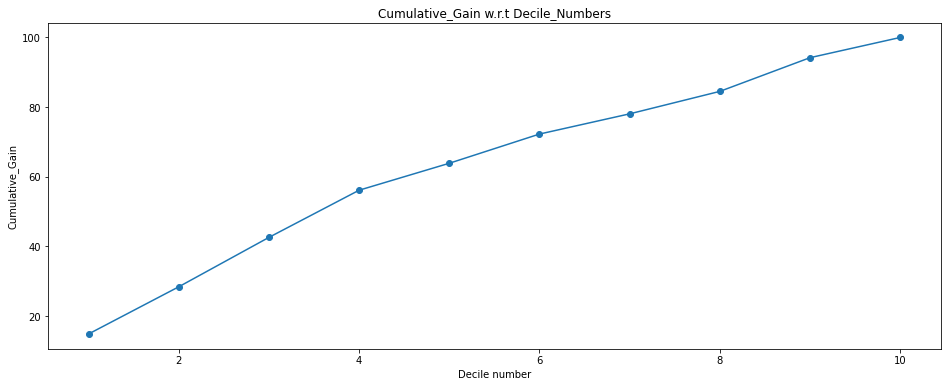

In [83]:
plt.figure(figsize=(16,6))
plt.xlabel("Decile number")
plt.ylabel("Cumulative_Gain")
plt.title("Cumulative_Gain w.r.t Decile_Numbers")
plt.plot(final_df["Decile"], final_df['Cumulative_Gain'],marker='o')

# this graph looks correct to me. {small check - cg_10 = 100*(M_10/P) = 100.00 (we are correct)}

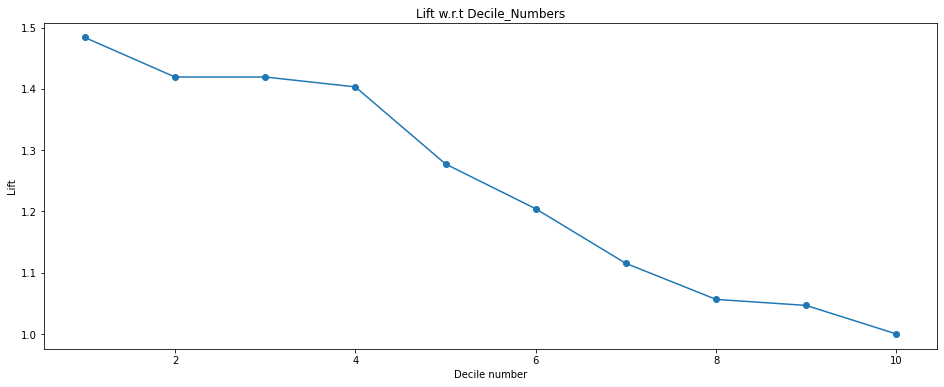

In [85]:
plt.figure(figsize=(16,6))
plt.xlabel("Decile number")
plt.ylabel("Lift")
plt.title("Lift w.r.t Decile_Numbers")
plt.plot(final_df["Decile"], final_df['Lift'],marker='o')

### Feature Importance

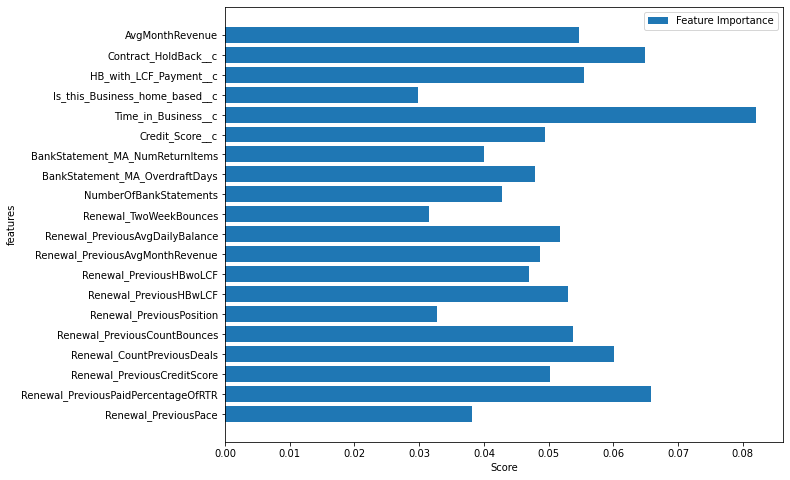

In [ ]:
features = X.columns
features
gain = clf.best_estimator_.feature_importances_
plt.figure(figsize = (10, 8))
plt.barh(features , gain)
plt.xlabel("Score")
plt.ylabel("features")
plt.legend(["Feature Importance"])
plt.show()

In [ ]:
#calibrating the model to get the probabilities
#calibration_clf = CalibratedClassifierCV(clf.best_estimator_)
#calibration_clf.fit(X_train,y_train)

### Predicted data for FN, FP, TP graphs

In [ ]:
def get_predicted_data(class_label,y_pred,y_prob,preprocessed_data):
    class_label_index = class_label.index.tolist()
    mac_address = []
    for ind in class_label_index:
        mac_address.append(preprocessed_data.iloc[ind]['mac_address'])
                
    return pd.DataFrame({'mac_address':mac_address,'actual_class':class_label,
                         'predicted_class':y_pred,'confidence_score':y_prob})

In [ ]:
preprocessed_data = pd.read_csv('feature_improved_V2.csv')

In [ ]:
predicted_data=get_predicted_data(y_test,predict_y_test,predict_y_proba_test.T[1], preprocessed_data)
predicted_data.to_csv('predicted_data_xgboost_V_NEW.csv',index=False)

In [ ]:
predicted_data.head()

In [ ]:
#features Importance
features = x.columns
features
gain = clf.best_estimator_.feature_importances_
plt.figure(figsize = (10, 8))
plt.barh(features , gain)
plt.xlabel("Score")
plt.ylabel("features")
plt.legend(["Feature Importance"])
plt.show()

NameError: ignored

### Prediction___to_be_analyses_____

In [ ]:
file = open("model_pickle",'rb')
object_file = pickle.load(file)

In [ ]:
def get_predicted_data(class_label,y_pred,y_prob,preprocessed_data):
    class_label_index = class_label.index.tolist()
    mac_address = []
    for ind in class_label_index:
        mac_address.append(preprocessed_data.iloc[ind]['mac_address'])
                
    return pd.DataFrame({'mac_address':mac_address,'actual_class':class_label,
                         'predicted_class':y_pred,'confidence_score':y_prob})

In [ ]:
def get_predicted_data(class_label,y_pred,y_prob,preprocessed_data):
    class_label_index = class_label.index.tolist()
    mac_address = []
    for ind in class_label_index:
        mac_address.append(preprocessed_data.iloc[ind]['mac_address'])
                
    return pd.DataFrame({'mac_address':mac_address,'actual_class':class_label,
                         'predicted_class':y_pred,'confidence_score':y_prob})

In [ ]:
preprocessed_data = pd.read_csv("test_v2.csv")

In [ ]:
predicted_data=get_predicted_data(test_y1,model_prediction,predict_y_proba_test1.T[1], preprocessed_data)

In [ ]:
predicted_data

In [ ]:
predicted_data.to_csv('predicted_test_v2.csv',index=False)

In [ ]:
with open('model_pickle','wb') as xgboost_model_pickle:
    pickle.dump(calibration_clf,xgboost_model_pickle)

In [ ]:
# we are saving the weights of the model using joblib
import joblib
model_file_name = "DEMO-local-xgboost-model"  
joblib.dump(calibration_clf, model_file_name) 